# Import packages

In [1]:
from datetime import timedelta

import numpy as np
import pandas as pd

from helper_functions import open_delays, create_timesteps

# Notebook settings

In [2]:
SCHEDULE_FILEPATH = r'Intermediates\GTFS_20190914\gtfs_stop_datetimes_corrected.csv'
REAL_FILEPATH = r'Intermediates\wmata_stop_datetimes.csv'

### Assign timestep settings
timestep_size = 60  # minutes
timeperiod_start = 5  # Hour going up to 24
timeperiod_end  = 23  # Hour going up to 24

# Load in data

In [3]:
schedule  = pd.read_csv(SCHEDULE_FILEPATH)
schedule['arrival_time'] = pd.to_datetime(schedule['arrival_time'], format='%Y-%m-%d %H:%M:%S')

print(f"{len(schedule):_}")
schedule.head(5)

4_809_781


,line_name,trip_id,shape_id,stop,arrival_time,previous_stop,next_stop
0,BLUE,3121350_18154_2019-09-14,46,G05,2019-09-14 06:54:00,NaN,G04
1,BLUE,3121350_18154_2019-09-14,46,G04,2019-09-14 06:57:00,G05,G03
2,GREEN,3120258_18154_2019-09-14,117,F11,2019-09-14 07:00:00,NaN,F10
3,RED,3122265_18154_2019-09-14,6,A15,2019-09-14 07:00:00,NaN,A14
4,BLUE,3121220_18154_2019-09-14,88,J03,2019-09-14 07:00:00,NaN,J02


In [4]:
real = pd.read_csv(REAL_FILEPATH)
real['ARRIVAL'] = pd.to_datetime(real['ARRIVAL'], format='%Y-%m-%d %H:%M:%S')

# We only care about trips that are part of an actual route
real = real[pd.notna(real['TRIP_ROUTE'])]

print(f"{len(real):_}")
real.head(5)

5_973_890


,TRIP_ROUTE,STOP_ID,NEXT_STOP_ID,ARRIVAL,TRIP_KEY
0,BLUE,C10,C09,2019-09-14 00:00:00,157107609
1,RED,A02,A01/C01,2019-09-14 00:00:02,157107847
3,GREEN,F05,F06,2019-09-14 00:00:05,157107893
4,RED,B07,B06/E06,2019-09-14 00:00:08,157107255
5,SILVER,N03,N02,2019-09-14 00:00:09,157106850


# Create trip sets

In [5]:
# Schedule trip set
trip_ids = []
line_names = []
first_stops = []
last_stops = []
times = []

schedule_trip_split = {trip_id[0]: data for trip_id, data in schedule.groupby(['trip_id'])}
amount_of_trips = len(schedule_trip_split)

for i, (trip_id, trip_data) in enumerate(schedule_trip_split.items()):
    if i % int(round(amount_of_trips / 10, 0)) == 0:
        print(f"{i:_} out of {amount_of_trips:_}")

    trip_ids.append(trip_id)
    line_names.append(trip_data.iloc[0]['line_name'])
    first_stops.append(trip_data.iloc[0]['stop'])
    last_stops.append(trip_data.iloc[-1]['stop'])
    times.append(trip_data.iloc[0]['arrival_time'])

schedule_trips = pd.DataFrame({'trip_id': trip_ids,
                               'line_name': line_names,
                               'first_stop': first_stops,
                               'last_stop': last_stops,
                               'time': times})
schedule_trips.to_csv(r'Intermediates\schedule_trips.csv', index=False)

print(f"{amount_of_trips:_} out of {amount_of_trips:_}")
schedule_trips.head(3)

0 out of 193_930
19_393 out of 193_930
38_786 out of 193_930
58_179 out of 193_930
77_572 out of 193_930
96_965 out of 193_930
116_358 out of 193_930
135_751 out of 193_930
155_144 out of 193_930
174_537 out of 193_930
193_930 out of 193_930


,trip_id,line_name,first_stop,last_stop,time
0,3036094_18184_2019-10-14,SILVER,G05,N06,2019-10-14 13:08:00
1,3036095_18184_2019-10-14,SILVER,G05,N06,2019-10-14 16:20:00
2,3036096_18184_2019-10-14,SILVER,G05,N06,2019-10-14 17:32:00


In [6]:
# Real trip set
trip_keys = []
line_names = []
first_stops = []
last_stops = []
times = []

real_trip_split = {trip_key[0]: trip_data for trip_key, trip_data in real.groupby(['TRIP_KEY'])}
amount_of_trips = len(real_trip_split)

for i, (trip_key, trip_data) in enumerate(real_trip_split.items()):
    if i % int(round(amount_of_trips / 10, 0)) == 0:
        print(f"{i:_} out of {amount_of_trips:_}")

    trip_keys.append(trip_key)
    line_names.append(trip_data.iloc[0]['TRIP_ROUTE'])
    first_stops.append(trip_data.iloc[0]['STOP_ID'])
    last_stops.append(trip_data.iloc[-1]['STOP_ID'])
    times.append(trip_data.iloc[0]['ARRIVAL'])

real_trips = pd.DataFrame({'trip_key': trip_keys,
                           'line_name': line_names,
                           'first_stop': first_stops,
                           'last_stop': last_stops,
                           'time': times})
real_trips.to_csv(r'Intermediates\real_trips.csv', index=False)

print(f"{amount_of_trips:_} out of {amount_of_trips:_}")
real_trips.head(3)

KeyboardInterrupt: 

# Match Trips

In [ ]:
## Maybe split per line and not per last stop, test which gets better results
schedule_stoptimes_trip_split = {trip_id[0]: data for (trip_id, data) in schedule.groupby(['trip_id'])}
real_stoptimes_trip_split = {trip_key[0]: data for (trip_key, data) in real.groupby(['TRIP_KEY'])}
amount_of_schedule_trips = len(schedule_stoptimes_trip_split)

schedule_trips_stop_split = {(first_stop, last_stop): data for (first_stop, last_stop), data in schedule_trips.groupby(['first_stop', 'last_stop'])}
real_trips_stop_split = {(first_stop, last_stop): data for (first_stop, last_stop), data in real_trips.groupby(['first_stop', 'last_stop'])}

trip_counter = 0
trip_matches = {}
for first_stop_last_stop, schedule_trips_i in schedule_trips_stop_split.items():
    if first_stop_last_stop not in real_trips_stop_split.keys():
        trip_counter += len(schedule_trips_i)
        print(f"{first_stop_last_stop}: 0 matched, 0 matches updated. Processed {trip_counter:_} out of {amount_of_schedule_trips:_}")
        continue

    match_counter = 0
    update_counter = 0
    real_trips_i = real_trips_stop_split[first_stop_last_stop]
    for _, schedule_trip in schedule_trips_i.iterrows():
        schedule_trip_start_time = schedule_trip['time']
        schedule_trip_stops = schedule_stoptimes_trip_split[schedule_trip['trip_id']]

        # Find all real trips that departure around 2 hour period around schedule trip start time
        possible_real = real_trips_i[(real_trips_i['time'] > (schedule_trip_start_time - timedelta(hours=1))) & \
                                     (real_trips_i['time'] < (schedule_trip_start_time + timedelta(hours=1)))].copy()
        if len(possible_real) == 0:
            # No matching real trips can be found
            count += 1
            continue

        # Select 3 real trips with closest departure time (time saving)
        possible_real['time_diff'] = [abs(time_diff.total_seconds()) for time_diff in (possible_real['time'] - schedule_trip_start_time)]
        possible_real = possible_real.sort_values(by=['time_diff'])
        possible_real = possible_real.head(3)

        # Next we check which real trips stop times match most closely with the schedule trip for all stops along their trip
        # First we check which stops are shared between all possible real trips so that the comparison is equal (some real trip miss stop data)
        possible_real['total_delay'] = [np.inf] * len(possible_real)
        stops_to_check = []
        real_stops_dict = {trip_key: real_stoptimes_trip_split[trip_key] for trip_key in possible_real['trip_key'].values}
        stops_to_check = [stop for stop in schedule_trip_stops['stop'].values if \
                          all([stop in real_stops['STOP_ID'].values for real_stops in real_stops_dict.values()])]

        # Then we go through all stations along the trip and sum up the time difference for all stop times of it and the schedule trip
        for index, possible in possible_real.iterrows():
            real_stops = real_stops_dict[possible['trip_key']]

            sched_times_dict = {stop: time for stop, time in zip(schedule_trip_stops['stop'].values, schedule_trip_stops['arrival_time'].values)}
            real_times_dict = {stop: time for stop, time in zip(real_stops['STOP_ID'].values, real_stops['ARRIVAL'].values)}
            
            possible_real.loc[index, 'total_delay'] = np.sum([abs((sched_times_dict[stop] - real_times_dict[stop]) / np.timedelta64(1, 's')) for \
                                                             stop in stops_to_check])
        
        # Then we select the real trip with the lowest total arrival time difference
        possible_real = possible_real.sort_values(by=['total_delay'], ascending=True)
        real_match = possible_real.iloc[0]
        
        # And we assign that match to the matching result dictionary
        real_match_trip_key = real_match['trip_key']
        
        if real_match_trip_key not in trip_matches.keys():
            trip_matches[real_match_trip_key] = (schedule_trip['trip_id'], real_match['total_delay'])
            match_counter += 1
        # If a schedule trip is already matched tot that real trip, check if the current match has a lower total arrival time difference, and if so, replace the match
        elif trip_matches[real_match_trip_key][1] > real_match['total_delay']:
            ## TODO: Rerun the match of the replaced trip in a way that it can not be put in front the next or behind the previous train?
            trip_matches[real_match_trip_key] = (schedule_trip['trip_id'], real_match['total_delay'])
            update_counter += 1

    trip_counter += len(schedule_trips_i)
    print(f"{first_stop_last_stop}: {match_counter:_} matched, {update_counter:_} matches updated. Processed {trip_counter:_} out of {amount_of_schedule_trips:_}")

('A01/C01', 'B11'): 0 matched, 0 matches updated. Processed 1 out of 193_930
('A02', 'A15'): 0 matched, 0 matches updated. Processed 2 out of 193_930
('A02', 'B11'): 2 matched, 0 matches updated. Processed 52 out of 193_930
('A04', 'B11'): 0 matched, 0 matches updated. Processed 53 out of 193_930
('A06', 'A08'): 0 matched, 0 matches updated. Processed 54 out of 193_930
('A06', 'A15'): 1 matched, 0 matches updated. Processed 103 out of 193_930
('A08', 'A02'): 0 matched, 0 matches updated. Processed 104 out of 193_930
('A08', 'A03'): 0 matched, 0 matches updated. Processed 105 out of 193_930
('A08', 'B04'): 0 matched, 0 matches updated. Processed 107 out of 193_930
('A08', 'B09'): 0 matched, 0 matches updated. Processed 109 out of 193_930
('A08', 'B11'): 223 matched, 1 matches updated. Processed 358 out of 193_930
('A09', 'A15'): 0 matched, 0 matches updated. Processed 359 out of 193_930
('A09', 'B11'): 0 matched, 0 matches updated. Processed 384 out of 193_930
('A11', 'A10'): 0 matched,

In [ ]:
trip_matches = pd.DataFrame({'real_trip_key': [int(trip_key) for trip_key in trip_matches.keys()],
                            'schedule_trip_id': [trip_matches[trip_key][0] for trip_key in trip_matches.keys()]})
print(f"{len(trip_matches):_} out of {len(schedule_trips):_} schedule trips can be matched to real trips")
trip_matches.to_csv(r'Intermediates\trip_matches.csv', index=False)

155_360 out of 193_930 schedule trips can be matched to real trips


# Get delay values

In [5]:
# Uncomment code to run notebook from here
trip_matches = pd.read_csv(r'Intermediate Results\trip_matches_2.csv')
trip_matches['real_trip_key'] = trip_matches['real_trip_key'].astype('Int64')
print(len(trip_matches))
trip_matches.head(3)

FileNotFoundError: [Errno 2] No such file or directory: 'Intermediate Results\\trip_matches_2.csv'

In [6]:
amount_of_trip_matches = len(trip_matches)
print(f"Amount of matched trips: {amount_of_trip_matches:_}")

matched_real_stoptimes = real[real['TRIP_KEY'].isin(trip_matches['real_trip_key'])].copy()
print(f"Amount of real stoptimes associated with made matches: {len(matched_real_stoptimes):_}")

matched_schedule_stoptimes = schedule[schedule['trip_id'].isin(trip_matches['schedule_trip_id'])].copy()
print(f"Amount of scheduled stoptimes associated with made matches: {len(matched_schedule_stoptimes):_}")

delays = matched_schedule_stoptimes.copy()
delays['real_arrival_time'] = [None] * len(delays)
delays['delay'] = [None] * len(delays)

matched_schedule_stoptimes_trip_split = {trip_id[0]: data for trip_id, data in matched_schedule_stoptimes.groupby(['trip_id'])}
matched_real_stoptimes_trip_split = {trip_key[0]: data for trip_key, data in matched_real_stoptimes.groupby(['TRIP_KEY'])}
for i, (schedule_id, real_key) in enumerate(zip(trip_matches['schedule_trip_id'].values,
                                                trip_matches['real_trip_key'].values)):
    if i % int(round(amount_of_trip_matches / 10, 0)) == 0:
        print(f"{i:_} out of {amount_of_trip_matches:_} trip matches processed")

    matched_schedule_trip = matched_schedule_stoptimes_trip_split[schedule_id]
    matched_real_trip = matched_real_stoptimes_trip_split[real_key]

    # If the recorded stops match up between schedule and real trip, copying can be done using fast operations
    if len(matched_schedule_trip) == len(matched_real_trip):
        schedule_indecies = matched_schedule_trip.index
        delays.loc[schedule_indecies, 'real_arrival_time'] = matched_real_trip['ARRIVAL'].values
        delays.loc[schedule_indecies, 'delay'] = (matched_real_trip['ARRIVAL'].values - matched_schedule_trip['arrival_time'].values)
    # If stops dont matched, delays need to be calculated and recorder stop by stop
    else:
        for index, scheduled_stop in matched_schedule_trip.iterrows():
            if scheduled_stop['stop'] in matched_real_trip['STOP_ID'].values:
                matching_real_stop = matched_real_trip[matched_real_trip['STOP_ID'] == scheduled_stop['stop']].iloc[0]
                delays.at[index, 'real_arrival_time'] = matching_real_stop['ARRIVAL']
                delays.at[index, 'delay'] = (matching_real_stop['ARRIVAL'] - scheduled_stop['arrival_time'])

print(f"{i:_} out of {amount_of_trip_matches:_} trip matches processed")
delays['delay'] = [np.timedelta64(delay, 's') / np.timedelta64(1, 's') for delay in delays['delay'].values]
delays['real_arrival_time'] = pd.to_datetime(delays['real_arrival_time'])

NameError: name 'trip_matches' is not defined

In [ ]:
print(f"Totale matched schedule stoptimes: {len(delays):_}")
delays = delays[pd.notna(delays['delay'])]
print(f"Amount of valid delays: {len(delays):_}")
# delays.to_csv(r'Intermediates\delays.csv', index=False)
delays.head(5)

Totale matched schedule stoptimes: 3_873_811
Amount of valid delays: 3_873_811


,line_name,trip_id,shape_id,stop,arrival_time,previous_stop,next_stop,real_arrival_time,delay
0,BLUE,3121350_18154_2019-09-14,46,G05,2019-09-14 06:54:00,NaN,G04,2019-09-14 06:46:04,-476.0
1,BLUE,3121350_18154_2019-09-14,46,G04,2019-09-14 06:57:00,G05,G03,2019-09-14 06:56:12,-48.0
2,GREEN,3120258_18154_2019-09-14,117,F11,2019-09-14 07:00:00,NaN,F10,2019-09-14 06:45:42,-858.0
3,RED,3122265_18154_2019-09-14,6,A15,2019-09-14 07:00:00,NaN,A14,2019-09-14 06:54:17,-343.0
4,BLUE,3121220_18154_2019-09-14,88,J03,2019-09-14 07:00:00,NaN,J02,2019-09-14 06:59:04,-56.0


(-1500.0, 1500.0)

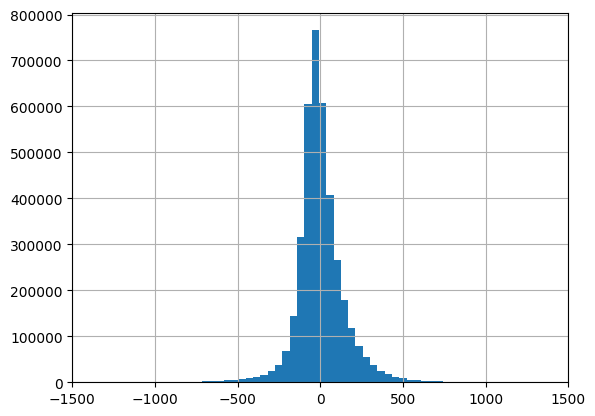

# Assign timestep

In [3]:
delays = open_delays(r'Intermediates\delays.csv')
delays.head(3)

Amount of delay values: 3_873_811


,line_name,trip_id,shape_id,stop,arrival_time,previous_stop,next_stop,real_arrival_time,delay
0,BLUE,3121350_18154_2019-09-14,46,G05,2019-09-14 06:54:00,NaN,G04,2019-09-14 06:46:04,-476.0
1,BLUE,3121350_18154_2019-09-14,46,G04,2019-09-14 06:57:00,G05,G03,2019-09-14 06:56:12,-48.0
2,GREEN,3120258_18154_2019-09-14,117,F11,2019-09-14 07:00:00,NaN,F10,2019-09-14 06:45:42,-858.0


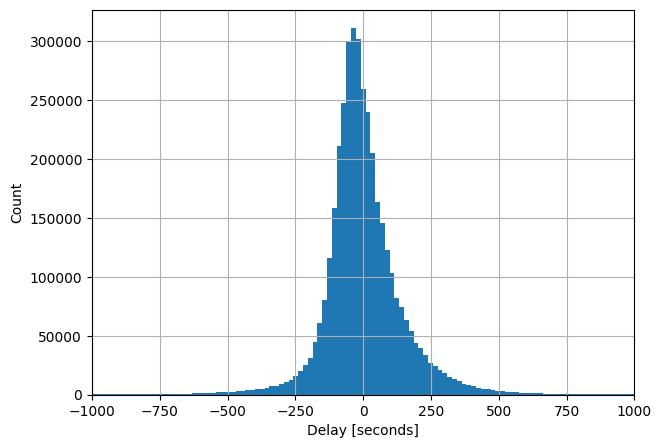

In [12]:
from matplotlib import pyplot as plt


plt.figure(figsize=(7, 5))

delays['delay'].hist(bins=500, density=False)
plt.xlim(-1000, 1000)

plt.xlabel('Delay [seconds]')
plt.ylabel('Count')

# plt.grid()

plt.savefig(r'Codebase figures\delay_histogram.png', dpi=300)

In [ ]:
# timesteps = create_timesteps(timestep_size, timeperiod_start, timeperiod_end)
# delays_assigned = delays.copy()
# delays_assigned = delays_assigned.rename(columns={'arrival_time': 'sched_arrival_time'})
# delays_assigned['timestep'] = [None] * len(delays_assigned)
# for time_step_begin, time_step_end in zip(timesteps[:-1], timesteps[1:]):
#     begin_seconds = time_step_begin[0] * 3600 + time_step_begin[1] * 60
#     end_seconds = time_step_end[0] * 3600 + time_step_end[1] * 60

#     single_step = delays_assigned[[((date.hour * 3600 + date.minute * 60 >= begin_seconds) & \
#                                              (date.hour * 3600 + date.minute * 60 <= end_seconds)) for \
#                                             date in delays_assigned['sched_arrival_time']]]
#     delays_assigned.loc[single_step.index, 'timestep'] = time_step_begin[0] + time_step_begin[1] / 60

# delays_assigned = delays_assigned[pd.notna(delays_assigned['timestep'])]
# print(f"Amount of values allocated to timesteps: {len(delays_assigned):_}")
# delays_assigned.head(3)

Amount of values allocated to timesteps: 3_802_649


,line_name,trip_id,shape_id,stop,sched_arrival_time,previous_stop,next_stop,real_arrival_time,delay,timestep
0,BLUE,3121350_18154_2019-09-14,46,G05,2019-09-14 06:54:00,NaN,G04,2019-09-14 06:46:04,-476.0,6.0
1,BLUE,3121350_18154_2019-09-14,46,G04,2019-09-14 06:57:00,G05,G03,2019-09-14 06:56:12,-48.0,6.0
2,GREEN,3120258_18154_2019-09-14,117,F11,2019-09-14 07:00:00,NaN,F10,2019-09-14 06:45:42,-858.0,7.0


In [ ]:
# delays_assigned.to_csv(r'Intermediates\delays_assigned.csv', index=False)